In [154]:
from new_stations import *
from time_series_model import *
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import acf, pacf
from scipy import signal
from scipy import stats








In [14]:
data, weather = load_data()

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


In [15]:
data = feature_addition(data)

In [16]:
sf = model_city(data,1)

In [90]:
def month_sep(df, year, month):
    cdf = df[(df.year == year) & (df.month == month)]
    ndf = df[(df.year == year) & (df.month == (month-1))]
    return cdf, ndf

In [198]:
#cdf = current month df
#ndf = next month df
cdf, ndf = month_sep(sf, 2018, 3)

In [199]:
#proposed stations
ps = new_stn_coords(cdf, ndf)

In [200]:
ps

[339.0, 191.0]

In [201]:
#neighbors for each proposed location
#id and coordinate combo for each station
neighbors, id_coord= knn_proposed_stn(cdf, ndf, ps)

In [202]:
neighbors

{339: [148, 155, 28], 191: [155, 163, 28]}

In [203]:
qtr = days_for_ts(sf, cdf,3)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [204]:
# t = 230
# print("The origin station is {}.".format(t))
# print("The 3 closest neighbors are: {}, {}, {}".format(int(neighbors.get(t)[0]),int(neighbors.get(t)[1]),int(neighbors.get(t)[2])))
# plt.figure(figsize = (10,10))
# ll,rr = -122.50, -122.36
# bb = 37.73
# plt.xlim(ll,rr)
# plt.ylim(bb, bb+(rr-ll))
# plt.xlabel("Longitude")
# plt.ylabel("Latitude")
# plt.title("Map of Ford GoBike stations in San Francisco")
# plt.scatter(qtr.end_station_longitude, qtr.end_station_latitude, s=1, c=('r'))
# plt.scatter(id_coord.get(t)[0], id_coord.get(t)[1], s=20, marker='x', c=('b'))

# for st in neighbors.get(t):
#     plt.scatter(id_coord.get(st)[0],id_coord.get(st)[1], s= 10, c='g')
# plt.show()



In [205]:
def plt_stn():
    row_sze = len(neighbors)
    col_sze = len(next(iter(neighbors.values())))
    rnge = row_sze*col_sze
    fig = plt.figure(figsize=(10,10))
    graph = 1
    for k, v in neighbors.items():
        num = 1
        for s_id in v:
            plt.subplot(rnge,1,graph)
            plt.subplots_adjust(top=6, bottom =0.1)
            plt.xlim(0,90)
            plt.xlabel("days")
            plt.ylabel("trips per day")
            plt.title("This is station {}, and it is neighbor #{} for station {}".format(s_id, num, k))
            ts = days_count(qtr, s_id)
            plt.plot(ts[:,0],ts[:,1])
            num+=1
            graph+=1

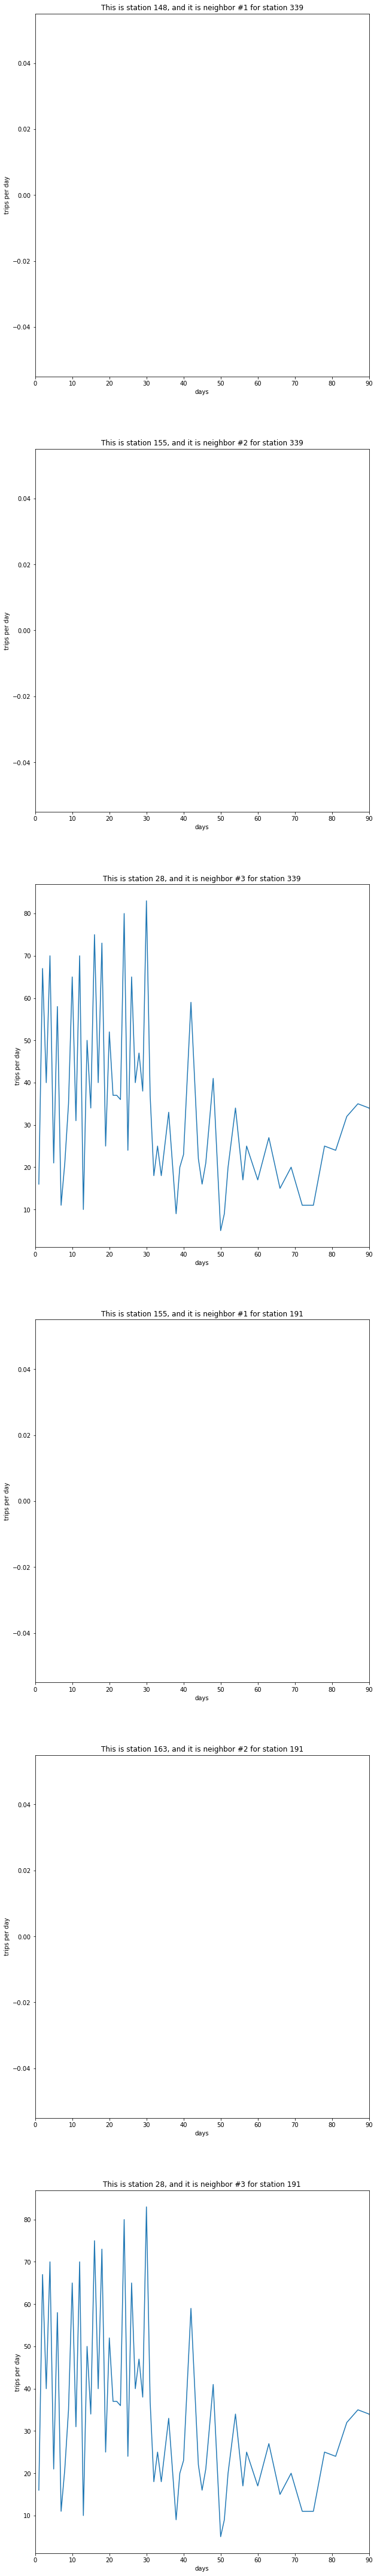

In [206]:
plt_stn()

In [211]:
ts = days_count(qtr, 28)

In [221]:
tseries = pd.Series(ts[:,1])
len(tseries)

61

In [213]:
test = sm.tsa.stattools.adfuller(tseries)
print("ADF p-value: {0:2.2f}".format(test[1]))

ADF p-value: 0.22


In [214]:
trip_matrix = tseries.as_matrix()
trip_matrix

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


array([16, 67, 40, 70, 21, 58, 11, 21, 35, 65, 31, 70, 10, 50, 34, 75, 40,
       73, 25, 52, 37, 37, 36, 80, 24, 65, 40, 47, 38, 83, 37, 18, 25, 18,
       33,  9, 20, 23, 59, 22, 16, 21, 41,  5,  9, 20, 34, 17, 25, 17, 27,
       15, 20, 11, 11, 25, 24, 32, 35, 34, 29])

In [215]:
trip_model = ARIMA(trip_matrix, order=(3, 1, 0)).fit()

In [216]:
predictions = trip_model.predict(75, 85, typ='levels')
predictions

array([31.58485348, 31.41048962, 32.1522129 , 29.88923337, 30.93897544,
       30.11072342, 30.79538694, 29.53578418, 30.08157706, 29.276812  ,
       29.7011682 , 28.87015841, 29.16252226, 28.50456748, 28.72168404,
       28.112905  , 28.2434283 , 27.71881207, 27.79426315, 27.31868927,
       27.33911262, 26.91292804, 26.89373838, 26.50418084, 26.44929467])

In [217]:
test = np.append(trip_matrix, predictions)

In [218]:
test1 = pd.Series(test)

In [219]:
test1

0     16.000000
1     67.000000
2     40.000000
3     70.000000
4     21.000000
5     58.000000
6     11.000000
7     21.000000
8     35.000000
9     65.000000
10    31.000000
11    70.000000
12    10.000000
13    50.000000
14    34.000000
15    75.000000
16    40.000000
17    73.000000
18    25.000000
19    52.000000
20    37.000000
21    37.000000
22    36.000000
23    80.000000
24    24.000000
25    65.000000
26    40.000000
27    47.000000
28    38.000000
29    83.000000
        ...    
56    24.000000
57    32.000000
58    35.000000
59    34.000000
60    29.000000
61    31.584853
62    31.410490
63    32.152213
64    29.889233
65    30.938975
66    30.110723
67    30.795387
68    29.535784
69    30.081577
70    29.276812
71    29.701168
72    28.870158
73    29.162522
74    28.504567
75    28.721684
76    28.112905
77    28.243428
78    27.718812
79    27.794263
80    27.318689
81    27.339113
82    26.912928
83    26.893738
84    26.504181
85    26.449295
Length: 86, dtype: float

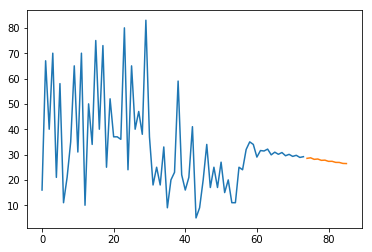

In [220]:
plt.plot(test1.index[0:74], test1[0:74])
plt.plot(test1.index[74:], test1[74:])


In [ ]:
def ARIMA_pred(series, p=1, d=0, q=1):
    tseries = pd.Series(series[:,1])
    test = sm.tsa.stattools.adfuller(tseries)
    trip_matrix = tseries.as_matrix()
    trip_model = ARIMA(trip_matrix, order=(p, d, q)).fit()
    
    predictions = trip_model.predict(len(tseries), len(tseries)+30, typ='levels')
    test = np.append(trip_matrix, predictions)
    test1 = pd.Series(test)
    plt.plot(test1.index[:], test1[0:74])
    plt.plot(test1.index[74:], test1[74:])



In [81]:
# #Print MSE to see how good the model is
# Error = mean_squared_error(TestData, Predictions)
# print('Test Mean Squared Error (smaller the better fit): %.3f' % Error)
# # plot
# pyplot.plot(TestData)
# pyplot.plot(Predictions, color='red')
# pyplot.show()

In [80]:
# #in a for loop, predict values using ARIMA model
# for timepoint in range(len(TestData)):
#     ActualValue =  TestData[timepoint]
#     #forcast value
#     Prediction = StartARIMAForecasting(Actual, 3,1,0)    
#     print('Actual=%f, Predicted=%f' % (ActualValue, Prediction))
#     Predictions.append(Prediction)
#     Actual.append(ActualValue)